# 4.5 Detecting Human Body Keypoints

Module - Deep Vision

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Reference: Chapter 6, [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715)

In [ ]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
     

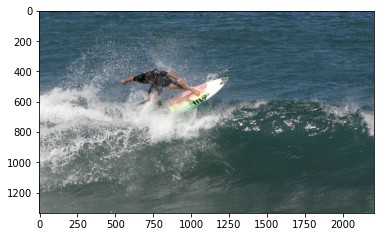

In [ ]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open('./media/surfer.jpg')

plt.imshow(img)
plt.show()

In [ ]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


{'boxes': tensor([[ 71.1658,  82.4167, 224.0000, 224.0000],
         [  6.8550,  61.4492,  97.0863, 101.2850],
         [ 11.4478, 135.8707,  26.5930, 155.4240],
         [  0.8797, 143.2476, 145.1720, 224.0000],
         [ 98.6388, 133.7877, 113.5992, 154.2878],
         [ 15.2188, 133.6465,  32.7526, 153.7075],
         [ 23.9866, 137.1798,  32.6855, 151.3453]], grad_fn=<StackBackward>),
 'keypoints': tensor([[[156.6802, 120.3308,   1.0000],
          [169.8362, 115.5741,   1.0000],
          [155.2806, 115.5741,   1.0000],
          [182.1525, 113.6154,   1.0000],
          [223.5801, 125.0876,   1.0000],
          [223.5801,  82.8364,   1.0000],
          [223.5801, 223.5803,   1.0000],
          [136.2463,  88.1528,   1.0000],
          [134.8467,  82.8364,   1.0000],
          [133.4471,  82.8364,   1.0000],
          [171.7957, 110.2577,   1.0000],
          [207.0651, 121.7299,   1.0000],
          [175.7145, 123.1289,   1.0000],
          [123.0902, 140.1973,   1.0000],
      

In [ ]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)


In [ ]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


'[{"nose": [757, 470, 1], "left_eye": [760, 458, 1], "right_eye": [744, 463, 1], "left_ear": [769, 445, 1], "right_ear": [712, 455, 1], "left_shoulder": [775, 412, 1], "right_shoulder": [676, 450, 1], "left_elbow": [869, 422, 1], "right_elbow": [611, 450, 1], "left_wrist": [927, 461, 1], "right_wrist": [566, 471, 1], "left_hip": [815, 470, 1], "right_hip": [769, 490, 1], "left_knee": [872, 503, 1], "right_knee": [749, 584, 1], "left_ankle": [1028, 529, 1], "right_ankle": [795, 617, 1]}]'

In [ ]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)
        
def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)
    
def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.show()

# draw_stickman(img, json_keypoints)

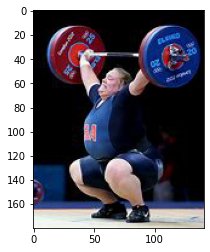

In [ ]:
img1 = Image.open('./media/weightlifter1.jpg')

plt.imshow(img1)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


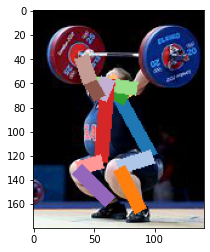

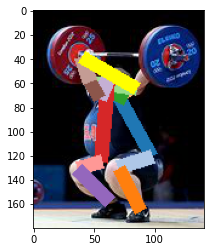

In [ ]:
keypoint_detections = get_keypoint_detections(img1)
json_keypoints = to_json(keypoint_detections)

def draw_stickman2(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    # print(colors[11])
    drawline(draw, z, 'right_wrist', 'left_wrist', [255, 255, 0, 255])
    plt.imshow(img)
    # plt.show()

draw_stickman(img1, json_keypoints)
draw_stickman2(img1, json_keypoints)

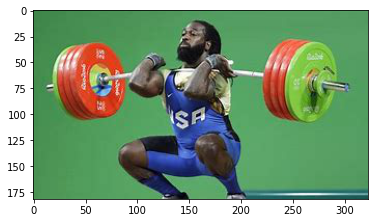

In [ ]:
img2 = Image.open('./media/weightlifter2.jpg')

plt.imshow(img2)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


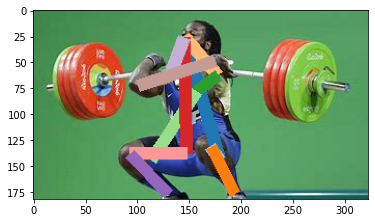

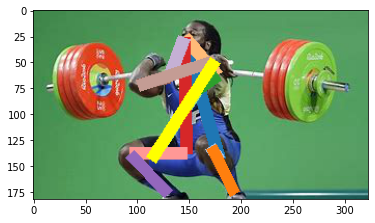

In [ ]:
keypoint_detections = get_keypoint_detections(img2)
json_keypoints = to_json(keypoint_detections)

draw_stickman(img2, json_keypoints)
draw_stickman2(img2, json_keypoints)

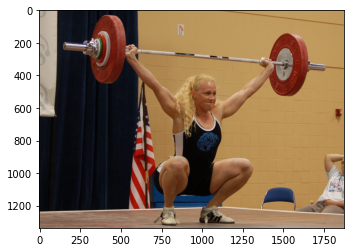

In [ ]:
img3 = Image.open('./media/weightlifter3.jpg')

plt.imshow(img3)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


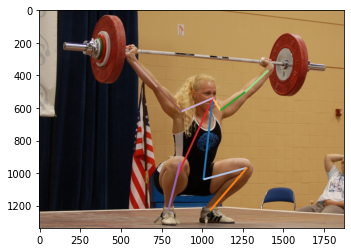

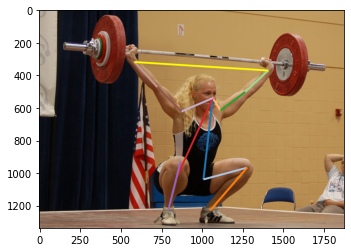

In [ ]:
keypoint_detections = get_keypoint_detections(img3)
json_keypoints = to_json(keypoint_detections)

draw_stickman(img3, json_keypoints)
draw_stickman2(img3, json_keypoints)

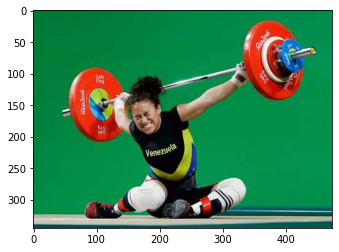

In [ ]:
img4 = Image.open('./media/weightlifter4.jpg')

plt.imshow(img4)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


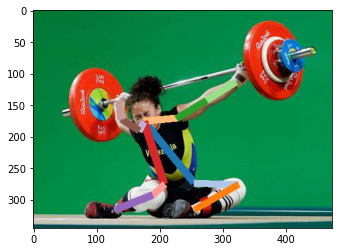

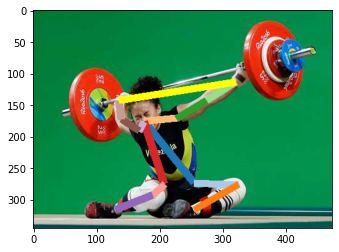

In [ ]:
keypoint_detections = get_keypoint_detections(img4)
json_keypoints = to_json(keypoint_detections)

draw_stickman(img4, json_keypoints)
draw_stickman2(img4, json_keypoints)

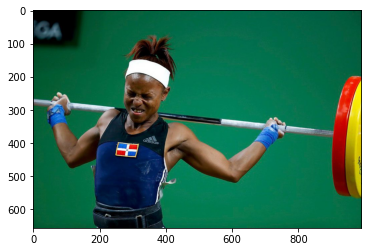

In [ ]:
img5 = Image.open('./media/weightlifter5.jpg')

plt.imshow(img5)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


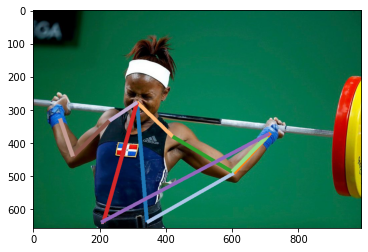

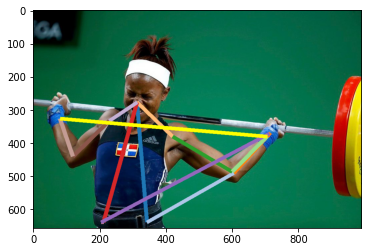

In [ ]:
keypoint_detections = get_keypoint_detections(img5)
json_keypoints = to_json(keypoint_detections)

draw_stickman(img5, json_keypoints)
draw_stickman2(img5, json_keypoints)

In [ ]:
import cv2
vidcap = cv2.VideoCapture('./media/Janez clean and jerk.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        with open("Bar height-Janez clean and jerk.csv", "a") as outF:
          cv2.imwrite("./media/Janez clean and jerk/image"+str(count)+".jpg", image)     # save frame as JPG file
          img = Image.open("./media/Janez clean and jerk/image"+str(count)+".jpg")
          keypoint_detections = get_keypoint_detections(img)
          json_keypoints = to_json(keypoint_detections)
          data = json.loads(json_keypoints)
          z = data[0]
          max_wrist_y = max(z['right_wrist'][1], z['left_wrist'][1])
          outF.write(str(sec) + ", " + str(max_wrist_y))
          outF.write("\n") 
          # draw_stickman2(img, json_keypoints)
          # img.save("./media/Janez clean and jerk/image"+str(count)+".jpg")
    return hasFrames
sec = 0
frameRate = 1/30 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


KeyboardInterrupt: ignored

In [ ]:
import cv2
import numpy as np
import re
import os
from os.path import isfile, join

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

pathIn= './media/Janez clean and jerk/'
pathOut = './media/Janez clean and jerk posed.mp4'
fps = 1/60
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = alphanum_key)
frame_array = []

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()